<a href="https://colab.research.google.com/github/JorgeAnsotegui/TFM/blob/main/Generate_json.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import shutil
import zipfile
import os

# Montar Google Drive
drive.mount('/content/drive')

# Definir las rutas de los archivos y directorios
source_file = '/content/drive/MyDrive/TFM/Polipos Segmentados.zip'
destination_dir = '/content/Dataset/Polipos'

# Crear el directorio si no existe
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Copiar el archivo
shutil.copy(source_file, destination_dir)
print(f'Archivo copiado a: {os.path.join(destination_dir, os.path.basename(source_file))}')

# Descomprimir el archivo ZIP
zip_path = os.path.join(destination_dir, os.path.basename(source_file))
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)
    print(f'Archivo descomprimido en: {destination_dir}')

Mounted at /content/drive
Archivo copiado a: /content/Dataset/Polipos/Polipos Segmentados.zip
Archivo descomprimido en: /content/Dataset/Polipos


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Definir las rutas de los archivos y directorios
source_dir = '/content/Dataset/Polipos/segmentación polipos 265'
destination_base_dir = '/content/Dataset/Polipos/TrainValTest'

# Crear directorios de destino si no existen
train_dir = os.path.join(destination_base_dir, 'train')
val_dir = os.path.join(destination_base_dir, 'val')
test_dir = os.path.join(destination_base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Listar todas las imágenes en el directorio fuente, excluyendo las que terminan en (1).jpg
all_images = [f for f in os.listdir(source_dir) if f.endswith('.jpg') and not f.endswith('(1).jpg')]

# Dividir las imágenes en train (60%), val (20%), y test (20%)
train_images, test_images = train_test_split(all_images, test_size=0.4, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

# Función para copiar imágenes a los directorios correspondientes
def copy_images(image_list, destination_dir):
    for image in image_list:
        source_file = os.path.join(source_dir, image)
        destination_file = os.path.join(destination_dir, image)
        shutil.copyfile(source_file, destination_file)

copy_images(train_images, train_dir)
copy_images(val_images, val_dir)
copy_images(test_images, test_dir)

print("División de imágenes completada.")


División de imágenes completada.


In [4]:
import cv2
import numpy as np

def detect_and_draw_red_vertices(image_path, output_path, distance_threshold=10):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Convertir la imagen al espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para detectar el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Obtener las posiciones de los píxeles amarillos
    yellow_pixels = np.argwhere(mask_yellow == 255)

    # Definir el rango de color rojo en HSV
    lower_red = np.array([0, 240, 2])
    upper_red = np.array([10, 255, 255])

    # Crear una máscara para detectar el color rojo
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # Obtener las posiciones de los píxeles rojos
    red_pixels = np.argwhere(mask_red == 255)

    # Crear una imagen en blanco (255) con las mismas dimensiones que la imagen original
    result = np.ones_like(image) * 255

    # Iterar sobre los píxeles rojos y pintar en negro si están cerca de los píxeles amarillos
    for red_pixel in red_pixels:
        for yellow_pixel in yellow_pixels:
            distance = np.linalg.norm(red_pixel - yellow_pixel)
            if distance <= distance_threshold:
                result[red_pixel[0], red_pixel[1]] = [0, 0, 0]
                break  # Salir del bucle interno si el píxel rojo está cerca de algún píxel amarillo

    # Guardar la imagen resultante
    cv2.imwrite(output_path, result)

# Ruta de la imagen de prueba
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ruta de salida para la imagen resultante
output_path = '/content/prueba_Aristas_V2_13.jpg'

# Distancia máxima para considerar que un píxel rojo está cerca de un píxel amarillo
distance_threshold = 10

# Detectar y dibujar los puntos rojos como vértices en negro y guardar la imagen
detect_and_draw_red_vertices(image_path, output_path, distance_threshold)

print(f"Imagen guardada en: {output_path}")


Imagen guardada en: /content/prueba_Aristas_V2_13.jpg


[]


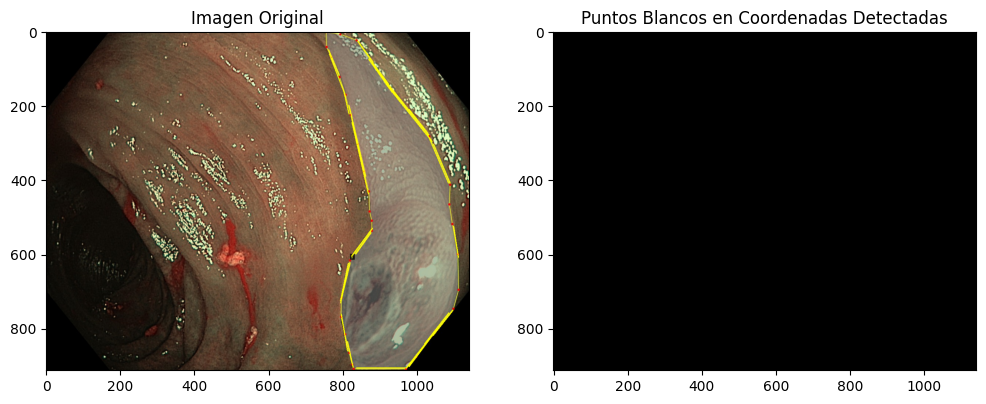

Coordenadas de círculos rojos cercanos a las líneas amarillas: []


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_ends.append((x1, y1))
                yellow_line_ends.append((x2, y2))
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

    return yellow_line_ends

def detect_red_circles(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color rojo en HSV
    lower_red = np.array([0, 240, 2])
    upper_red = np.array([10, 255, 255])

    # Crear una máscara para el color rojo
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # Aplicar un desenfoque para reducir el ruido y mejorar la detección de círculos
    blurred = cv2.GaussianBlur(mask_red, (9, 9), 2)

    # Detectar círculos usando la transformada de Hough
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=20,
                               param1=50, param2=30, minRadius=1, maxRadius=30)

    red_circles = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            red_circles.append((x, y, r))
            cv2.circle(image, (x, y), r, (0, 0, 255), 3)
    print(red_circles)
    return red_circles

def find_nearby_circles(yellow_line_ends, red_circles, distance_threshold=10):
    nearby_circles = []
    for y_end in yellow_line_ends:
        for circle in red_circles:
            x, y, r = circle
            distance = np.linalg.norm(np.array(y_end) - np.array((x, y)))
            if distance < distance_threshold:
                nearby_circles.append((x, y, r))
    return nearby_circles

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_ends = detect_yellow_lines(image)

    # Detectar círculos rojos
    red_circles = detect_red_circles(image)

    # Encontrar círculos rojos cercanos a los extremos de las líneas amarillas
    nearby_circles = find_nearby_circles(yellow_line_ends, red_circles)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos blancos en las coordenadas de los círculos cercanos
    for circle in nearby_circles:
        x, y, _ = circle
        cv2.circle(black_image, (x, y), 2, (255, 255, 255), -1)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos blancos
    plt.subplot(1, 2, 2)
    plt.title('Puntos Blancos en Coordenadas Detectadas')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver la lista de círculos rojos cercanos
    return nearby_circles

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
nearby_red_circles = main(image_path)
print("Coordenadas de círculos rojos cercanos a las líneas amarillas:", nearby_red_circles)


Amarillos [(919, 139), (1032, 279), (837, 907), (973, 907), (817, 200), (862, 391), (870, 75), (933, 164), (825, 246), (869, 438), (917, 143), (1041, 297), (1025, 269), (1085, 409), (1044, 819), (1097, 752), (1021, 842), (1086, 759), (1099, 525), (1112, 609), (979, 903), (1055, 802), (973, 905), (1040, 820), (1045, 304), (1090, 409), (764, 62), (808, 176), (979, 211), (1028, 273), (794, 732), (820, 624), (796, 762), (813, 861), (881, 86), (923, 142), (762, 50), (791, 118), (824, 606), (880, 531), (841, 27), (882, 84), (813, 836), (828, 905), (835, 600), (876, 543), (880, 86), (946, 177), (804, 167), (817, 223), (794, 726), (815, 625)]
Rojos []


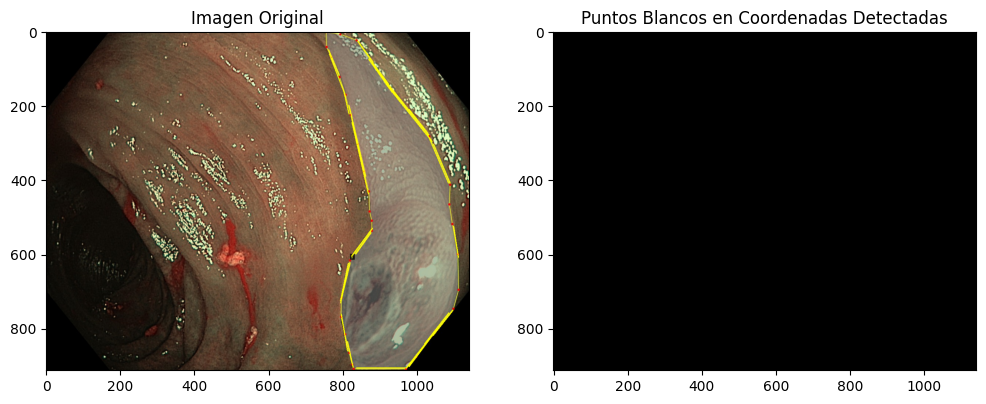

Coordenadas de círculos rojos cercanos a las líneas amarillas: []


In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_ends.append((x1, y1))
                yellow_line_ends.append((x2, y2))
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)
    print("Amarillos",yellow_line_ends)
    return yellow_line_ends

def detect_red_circles(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color rojo en HSV
    lower_red = np.array([0, 240, 2])
    upper_red = np.array([10, 255, 255])

    # Crear una máscara para el color rojo
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # Aplicar un desenfoque para reducir el ruido y mejorar la detección de círculos
    blurred = cv2.GaussianBlur(mask_red, (3, 3), 2)

    # Detectar círculos usando la transformada de Hough
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=10,
                               param1=100, param2=20, minRadius=1, maxRadius=10)

    red_circles = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            red_circles.append((x, y, r))
            cv2.circle(image, (x, y), r, (0, 0, 255), 3)
    print("Rojos",red_circles)
    return red_circles

def find_nearby_circles(yellow_line_ends, red_circles, distance_threshold=10):
    nearby_circles = []
    for y_end in yellow_line_ends:
        for circle in red_circles:
            x, y, r = circle
            distance = np.linalg.norm(np.array(y_end) - np.array((x, y)))
            if distance < distance_threshold:
                nearby_circles.append((x, y, r))
    return nearby_circles

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_ends = detect_yellow_lines(image)

    # Detectar círculos rojos
    red_circles = detect_red_circles(image)

    # Encontrar círculos rojos cercanos a los extremos de las líneas amarillas
    nearby_circles = find_nearby_circles(yellow_line_ends, red_circles)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos blancos en las coordenadas de los círculos cercanos
    for circle in nearby_circles:
        x, y, _ = circle
        cv2.circle(black_image, (x, y), 2, (255, 255, 255), -1)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos blancos
    plt.subplot(1, 2, 2)
    plt.title('Puntos Blancos en Coordenadas Detectadas')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver la lista de círculos rojos cercanos
    return nearby_circles

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
nearby_red_circles = main(image_path)
print("Coordenadas de círculos rojos cercanos a las líneas amarillas:", nearby_red_circles)


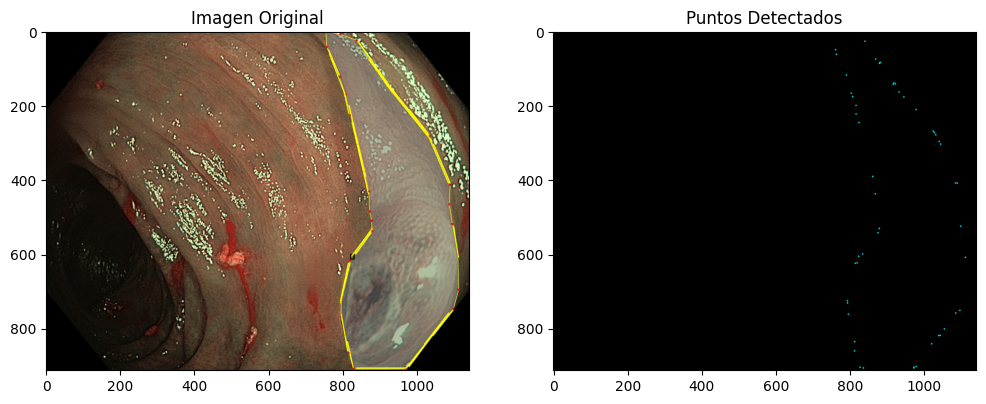

Coordenadas de círculos rojos cercanos a las líneas amarillas: []


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_ends.append((x1, y1))
                yellow_line_ends.append((x2, y2))
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

    return yellow_line_ends

def detect_red_circles(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color rojo en HSV
    lower_red = np.array([0, 240, 2])
    upper_red = np.array([10, 255, 255])

    # Crear una máscara para el color rojo
    mask_red = cv2.inRange(hsv, lower_red, upper_red)

    # Aplicar un desenfoque para reducir el ruido y mejorar la detección de círculos
    blurred = cv2.GaussianBlur(mask_red, (3, 3), 2)

    # Detectar círculos usando la transformada de Hough
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=10,
                               param1=100, param2=20, minRadius=1, maxRadius=10)

    red_circles = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            red_circles.append((x, y, r))
            cv2.circle(image, (x, y), r, (0, 0, 255), 3)

    return red_circles

def find_nearby_circles(yellow_line_ends, red_circles, distance_threshold=10):
    nearby_circles = []
    for y_end in yellow_line_ends:
        for circle in red_circles:
            x, y, r = circle
            distance = np.linalg.norm(np.array(y_end) - np.array((x, y)))
            if distance < distance_threshold:
                nearby_circles.append((x, y, r))
    return nearby_circles

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_ends = detect_yellow_lines(image)

    # Detectar círculos rojos
    red_circles = detect_red_circles(image)

    # Encontrar círculos rojos cercanos a los extremos de las líneas amarillas
    nearby_circles = find_nearby_circles(yellow_line_ends, red_circles)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos blancos en las coordenadas de los círculos cercanos
    for circle in nearby_circles:
        x, y, _ = circle
        cv2.circle(black_image, (x, y), 2, (255, 255, 255), -1)

    # Pintar puntos cian en los extremos de las líneas amarillas
    for end in yellow_line_ends:
        cv2.circle(black_image, end, 2, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos blancos y cian
    plt.subplot(1, 2, 2)
    plt.title('Puntos Detectados')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver la lista de círculos rojos cercanos
    return nearby_circles

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
nearby_red_circles = main(image_path)
print("Coordenadas de círculos rojos cercanos a las líneas amarillas:", nearby_red_circles)


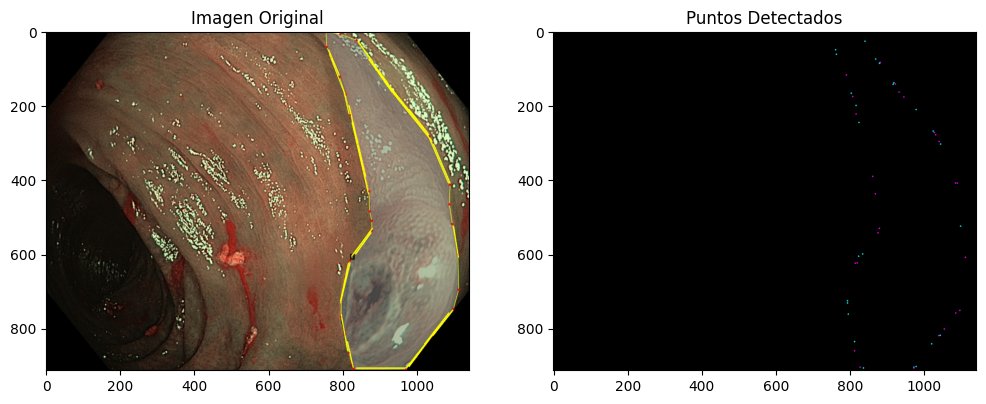

Coordenadas de los inicios de las líneas amarillas: [(919, 139), (837, 907), (817, 200), (870, 75), (825, 246), (917, 143), (1025, 269), (1044, 819), (1021, 842), (1099, 525), (979, 903), (973, 905), (1045, 304), (764, 62), (979, 211), (794, 732), (796, 762), (881, 86), (762, 50), (824, 606), (841, 27), (813, 836), (835, 600), (880, 86), (804, 167), (794, 726)]
Coordenadas de los finales de las líneas amarillas: [(1032, 279), (973, 907), (862, 391), (933, 164), (869, 438), (1041, 297), (1085, 409), (1097, 752), (1086, 759), (1112, 609), (1055, 802), (1040, 820), (1090, 409), (808, 176), (1028, 273), (820, 624), (813, 861), (923, 142), (791, 118), (880, 531), (882, 84), (828, 905), (876, 543), (946, 177), (817, 223), (815, 625)]


In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_starts = []
    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_starts.append((x1, y1))
                yellow_line_ends.append((x2, y2))
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

    return yellow_line_starts, yellow_line_ends

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_starts, yellow_line_ends = detect_yellow_lines(image)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos cian en los inicios de las líneas amarillas
    for start in yellow_line_starts:
        cv2.circle(black_image, start, 2, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)

    # Pintar puntos magenta en los finales de las líneas amarillas
    for end in yellow_line_ends:
        cv2.circle(black_image, end, 2, (255, 0, 255), -1)  # Color magenta (BGR: 255, 0, 255)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos cian y magenta
    plt.subplot(1, 2, 2)
    plt.title('Puntos Detectados')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver las listas de inicios y finales de líneas
    return yellow_line_starts, yellow_line_ends

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
yellow_line_starts, yellow_line_ends = main(image_path)
print("Coordenadas de los inicios de las líneas amarillas:", yellow_line_starts)
print("Coordenadas de los finales de las líneas amarillas:", yellow_line_ends)


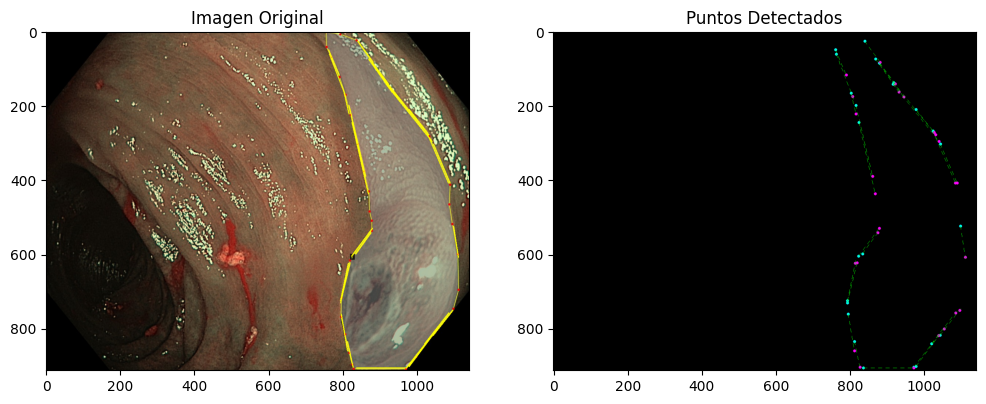

Coordenadas de los inicios de las líneas amarillas: [(919, 139), (837, 907), (817, 200), (870, 75), (825, 246), (917, 143), (1025, 269), (1044, 819), (1021, 842), (1099, 525), (979, 903), (973, 905), (1045, 304), (764, 62), (979, 211), (794, 732), (796, 762), (881, 86), (762, 50), (824, 606), (841, 27), (813, 836), (835, 600), (880, 86), (804, 167), (794, 726)]
Coordenadas de los finales de las líneas amarillas: [(1032, 279), (973, 907), (862, 391), (933, 164), (869, 438), (1041, 297), (1085, 409), (1097, 752), (1086, 759), (1112, 609), (1055, 802), (1040, 820), (1090, 409), (808, 176), (1028, 273), (820, 624), (813, 861), (923, 142), (791, 118), (880, 531), (882, 84), (828, 905), (876, 543), (946, 177), (817, 223), (815, 625)]


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_yellow_lines(image):
    # Convertir la imagen a espacio de color HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Definir el rango de color amarillo en HSV
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    # Crear una máscara para el color amarillo
    mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # Aplicar detección de bordes usando Canny
    edges = cv2.Canny(mask_yellow, 50, 150)

    # Detectar líneas usando la transformada de Hough
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=10)

    yellow_line_starts = []
    yellow_line_ends = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                yellow_line_starts.append((x1, y1))
                yellow_line_ends.append((x2, y2))
                cv2.line(image, (x1, y1), (x2, y2), (0, 255, 255), 2)

    return yellow_line_starts, yellow_line_ends

def draw_dashed_line(img, start_point, end_point, color, thickness=1, dash_length=10):
    # Función para dibujar una línea discontinua
    x1, y1 = start_point
    x2, y2 = end_point
    dx = x2 - x1
    dy = y2 - y1
    dist = int(np.sqrt(dx**2 + dy**2))
    for i in range(0, dist, dash_length*2):
        start = (int(x1 + (dx * i) / dist), int(y1 + (dy * i) / dist))
        end = (int(x1 + (dx * (i + dash_length)) / dist), int(y1 + (dy * (i + dash_length)) / dist))
        cv2.line(img, start, end, color, thickness)

def main(image_path):
    # Cargar la imagen
    image = cv2.imread(image_path)

    # Detectar líneas amarillas
    yellow_line_starts, yellow_line_ends = detect_yellow_lines(image)

    # Crear una nueva imagen negra del mismo tamaño
    black_image = np.zeros_like(image)

    # Pintar puntos cian en los inicios de las líneas amarillas
    for start in yellow_line_starts:
        cv2.circle(black_image, start, 4, (255, 255, 0), -1)  # Color cian (BGR: 255, 255, 0)

    # Pintar puntos magenta en los finales de las líneas amarillas
    for end in yellow_line_ends:
        cv2.circle(black_image, end, 4, (255, 0, 255), -1)  # Color magenta (BGR: 255, 0, 255)

    # Pintar líneas discontinuas en verde lima entre los puntos iniciales y finales
    for start, end in zip(yellow_line_starts, yellow_line_ends):
        draw_dashed_line(black_image, start, end, (0, 255, 0), thickness=1)  # Color verde lima (BGR: 0, 255, 0)

    # Mostrar la imagen original con los resultados
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Imagen Original')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Mostrar la nueva imagen con puntos cian y magenta y líneas discontinuas verdes
    plt.subplot(1, 2, 2)
    plt.title('Puntos Detectados')
    plt.imshow(cv2.cvtColor(black_image, cv2.COLOR_BGR2RGB))
    plt.show()

    # Devolver las listas de inicios y finales de líneas
    return yellow_line_starts, yellow_line_ends

# Ruta de la imagen a procesar
image_path = '/content/Dataset/Polipos/TrainValTest/test/100H0017.jpg'

# Ejecutar el programa
yellow_line_starts, yellow_line_ends = main(image_path)
print("Coordenadas de los inicios de las líneas amarillas:", yellow_line_starts)
print("Coordenadas de los finales de las líneas amarillas:", yellow_line_ends)
